In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from functools import  total_ordering
import copy

def get_values(data):
    result = []
    for x in data:
        result.append(x.value)
    return result

def get_deltas(data):
    result = []
    for x in data:
        result.append(x.delta)
    return result

def kovar(x_data, y_data):
    x = np.array(x_data)
    y = np.array(y_data)
    return (x*y).mean() - x.mean() * y.mean()

def mnk_non_zero(x_data, y_data):
    x =  np.array(x_data)
    y = np.array(y_data)
    k = kovar(x, y) / kovar (x, x)
    b = y.mean()-k*x.mean()

    sigma_k = ((kovar(y, y)/kovar(x,x) - k**2) / (len(x)-2) )**0.5
    sigma_b = sigma_k * (x**2).mean()**0.5
    return (DData(k, sigma_k)), (DData(b, sigma_b))

def linearcalc(x, y, xmin = None, xmax = None):
    plt.grid(True)
    plt.plot(x, y, "o")
    k, b = mnk_non_zero(x, y)
    if(xmin == None):
        xmin = x.min().value
    if(xmax == None):
        xmax = x.max().value
    xl = np.array([xmin, xmax])
    plt.plot(xl, xl*k.value + b.value)
    print("k, b =", k, b)
    return k, b

def linearcalc_error(x, y, xmin = None, xmax = None, label = "None"):
    plt.grid(True)
    if(type(x[0]) == DData):
        x_value = x.apply(lambda x: x.value)
        x_error = x.apply(lambda x: x.delta)
    else:
        x_value = x
        x_error = [0]*len(x_value)
    if(type(y[0]) == DData):
        y_value = y.apply(lambda y: y.value)
        y_error = y.apply(lambda y: y.delta)
    else:
        y_value = y
        y_error = [0]*len(y_error)
    k, b = mnk_non_zero(x_value, y_value)

    if(xmin == None):
        xmin = x.min().value
    if(xmax == None):
        xmax = x.max().value
    xl = np.array([xmin, xmax])

    plt.errorbar(x = x_value, y = y_value, xerr=x_error, yerr=y_error, fmt = "o", ms = 1, label = label)
    
    xl = np.array([xmin-(xmax-xmin)*0.1, xmax +(xmax-xmin)*0.1])
    print(xl)
    plt.plot(xl, xl*k.value + b.value)
    print("k, b =", k, b)
    return k, b

class SerDData():
    """Запихиваешь сюда свою дату похожу на пандасовсвую серию и вызываешь ее параметры"""
    def __init__(self, data):
        try:
            self.data = pd.Series(data)
            self.data = self.data.dropna()
            #self.data = self.data.apply(SerDData.ConvertIfNotDData)
        except:
            raise Exception(f"Нифига не получилось. data = {data}")
        
    def ConvertIfNotDData(x):
        if(type(x) != DData):
            return DData(x)
    @property
    def sigmaRaspr(self):    
        mean = self.meanValue
        return (self.data.map(lambda x: (x.value - mean)**2).sum()/len(self.data))**0.5

    @property
    def meanValue(self):    
        return self.meanStupid.value

    @property
    def sigmaSluch(self):
        n = len(self.data)
        return(self.sigmaRaspr / (n*(n-1))**0.5)
    
    @property
    def sigmaPrib(self):
        return self.meanStupid.delta
    
    @property
    def meanStupid(self):
        result = self.data.sum()/len(self.data)
        result.delta *= (len(self.data))**0.5
        return(result)

    @property
    def mean(self):
        mean = self.meanStupid
        mean.delta = (mean.delta**2 + self.sigmaSluch**2)**0.5
        return mean

    @property
    def sigma(self):
        return self.mean.delta
    
@total_ordering
class DData():
    def __init__(self, value = 0, delta = 0, epsilon = 0, E = 0):
        self.__value = 0
        self.__delta = 0
        self.__E = E
        self.value = value
        assert (delta == 0 or epsilon == 0), "При задании можно указать только один тип погрешности"
        
        if(delta!=0):
            self.delta = delta
        elif(epsilon!=0):
            self.epsilon = epsilon
    
    @property
    def E(self):
        return self.__E
    
    @E.setter
    def E(self, value):
        self.value *= 10**(self.E-value)
        self.delta *= 10**(self.E-value)
        self.__E = value

    @property
    def value(self):
        return self.__value

    @value.setter
    def value(self, value):
        if(isinstance(value, DData)):
            self.__value = value.value
            self.__delta = value.delta
            self.__E = value.E
        elif(isinstance(value, (int, float))):
            self.__value = value 
        else:
            assert False, "Значение должно быть числом"

    @property
    def epsilon(self):
        if(self.value == 0):
            return 0
        return self.delta/self.value
    @epsilon.setter
    def epsilon(self, epsilon):
        self.delta = abs(self.value*epsilon)

    @property
    def delta(self):
        return self.__delta
    @delta.setter
    def delta(self, delta):
        self.__delta = delta

    def __str__(self):
        #return(f"{self.__value} \\pm {self.__delta}")
        return self.LaTeX()
    def to_str(self, LaTeX = False, E = False):
        try:
            if(self.delta != 0):
                znak = -int((np.log10(self.delta))//1)+1
            else:
                znak = 1
        except:
            warnings.warn(f"попытка вывести какую-то хрень. value = {self.value}, delta = {self.delta}")
            return "NaN"
        try:
            form = f".{znak}f"
            value_str = round(self.value, znak)

            delta_str = round(self.delta, znak)

            value_str = format(value_str, form)
            delta_str = format(delta_str, form)

            if LaTeX:
                return f"${value_str} \pm {delta_str}$"
            elif not E or self.E == 0:

                return (f"{value_str} \pm {delta_str}")
            else:
                return (f"{value_str} \pm {delta_str} \cdot 10^{E}")
        except:
            warnings.warn("Что-то сломалось при отображении ")
            return f"${round(self.value, znak)} \pm {round(self.delta, znak)}$"
    def __neg__(self):
        return DData(-self.value, self.delta, E = self.E)

    def __add__(self, other):
        other = DData(other)
        if(self.E == other.E):
            return(DData(self.value + other.value, (self.delta**2 + other.delta**2)**0.5, E = self.E))
        else:
            newE = min(self.E, other.E)
            other.E = newE
            newSelf = DData(self)
            newSelf.E = newE
            return(newSelf+other)
           
    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return -(self - other)
    
    def __mul__(self, other):
        other = DData(other)
        return DData(self.value * other.value, epsilon=(self.epsilon**2 + other.epsilon**2)**0.5, E = self.E + other.E)
        
    def __rmul__(self, other):
        return self*other
        
    def __truediv__(self, other):
        if(isinstance(other, (int, float, DData))):
            other = DData(other)
            return DData(self.value / other.value, epsilon=(self.epsilon**2 + other.epsilon**2)**0.5, E = self.E - other.E)
        elif (isinstance(other, pd.Series)):
            return 1/other * self
        else:
            assert False, f"А фиг тебе, я не умею делить на {other} типа {type(other)}"
        
    def __rtruediv__(self, other):
        return (DData(1)/self) * other
    
    def __pow__(self, other):
        if(isinstance(other, (int, float))):
            return DData(self.value**other, epsilon=other*self.epsilon, E = self.E * other)
        else:
            assert False, "Пока можно возводить только в степень точного числа"
    
    def __eq__(self, other):
        if not(isinstance(other, DData)):
            other = DData(other)
        return (self.value == other.value) and (self.delta == other.delta)

    def __lt__(self, other):
        if not(isinstance(other, DData)):
            other = DData(other)
        return (self.value < other.value)

    def LaTeX(self):
        return self.to_str(True)
    
    def changeE(self, E):
        try:
            self.E = E
            return True
        except:
            return False

    @staticmethod
    def tryConvert(x, delta = 0, epsilon = 0, E = 0):
        try:
            if(pd.isna(x)):
                return x
            return DData(float(x), delta = delta, epsilon = epsilon, E = E)
        except:
            return x
    def changeEInSerias(series : pd.Series, E):
        series.dropna().apply(lambda x: x.changeE(E))
    def Log(x):
        if not(isinstance(x, DData)):
            x = DData(x)
        return(DData(np.log(x.value), x.epsilon))
    



<>:202: SyntaxWarning: invalid escape sequence '\p'
<>:205: SyntaxWarning: invalid escape sequence '\p'
<>:207: SyntaxWarning: invalid escape sequence '\p'
<>:207: SyntaxWarning: invalid escape sequence '\c'
<>:210: SyntaxWarning: invalid escape sequence '\p'
<>:202: SyntaxWarning: invalid escape sequence '\p'
<>:205: SyntaxWarning: invalid escape sequence '\p'
<>:207: SyntaxWarning: invalid escape sequence '\p'
<>:207: SyntaxWarning: invalid escape sequence '\c'
<>:210: SyntaxWarning: invalid escape sequence '\p'
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_17972\915393019.py:202: SyntaxWarning: invalid escape sequence '\p'
  return f"${value_str} \pm {delta_str}$"
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_17972\915393019.py:205: SyntaxWarning: invalid escape sequence '\p'
  return (f"{value_str} \pm {delta_str}")
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_17972\915393019.py:207: SyntaxWarning: invalid escape sequence '\p'
  return (f"{value_str} \pm {delta_str} \cdot 10^{E

In [6]:
def T_UP(data : pd.DataFrame):
    up  = []
    for i in data.index:
        if(i == 0):
            up.append(True)
        elif(data["T"][i] > data["T"][i-1]):
            up.append(True)
        else:
            up.append(False)
    up = pd.Series(up)
    return data[up]

def T_DOWN(data : pd.DataFrame):
    up  = []
    for i in data.index:
        if(i == 0):
            up.append(False)
        elif(data["T"][i] > data["T"][i-1]):
            up.append(False)
        else:
            up[i-1] = True
            up.append(True)
    up = pd.Series(up)
    return data[up]

In [7]:
def calc_det(x : pd.Series, y : pd.Series):
    if(len(x) < 5):
        print("ERROR")
        return [0]*len(x)
    dets = [0]*len(x)
    for i in range(2, len(x)-2):
        x_srez = x[i-2:i+3]
        y_srez = y[i-2:i+3]
        k, _ = mnk_non_zero(x_srez, y_srez)
        dets[i] = k
    dets[0], dets[1], dets[-1], dets[-2] = dets[2], dets[2], dets[-3], dets[-3]
    return (dets)


ERROR
ERROR
[-60.44848344004868, -60.44848344004868, -60.44848344004868, -69.45531706154014, -73.13296588645083, -75.77020226191692, -81.25341765025394, -86.5468445650328, -83.05803223857357, -83.05803223857357, -83.05803223857357]


,T,h1,h2,h,P,k1,k2,L1,L2
0,30.10,80.9,53.1,27.8,3708964.8,245431.594502,-60.448483,498.209233,502.326897
1,31.09,81.5,52.8,28.7,3829039.2,245431.594502,-60.448483,514.852854,502.326897
2,32.07,82.5,51.9,30.6,4082529.6,245431.594502,-60.448483,513.807063,502.326897
3,33.07,83.8,50.9,32.9,4389386.4,277348.690466,-69.455317,574.237724,577.173685
4,34.00,84.8,50.1,34.7,4629535.2,294543.204020,-73.132966,611.181886,607.734947
5,35.20,85.8,48.6,37.2,4963075.2,307711.510104,-75.770202,638.379947,629.650381
6,36.00,87.1,47.6,39.5,5269932.0,330627.974571,-81.253418,675.679294,675.215901
7,37.00,88.4,46.5,41.9,5590130.4,354299.070111,-86.546845,721.028690,719.204278
8,37.95,89.9,45.5,44.4,5923670.4,341274.360507,-83.058032,689.504905,690.212248
9,38.95,91.2,43.9,47.3,6310576.8,341274.360507,-83.058032,681.789884,690.212248


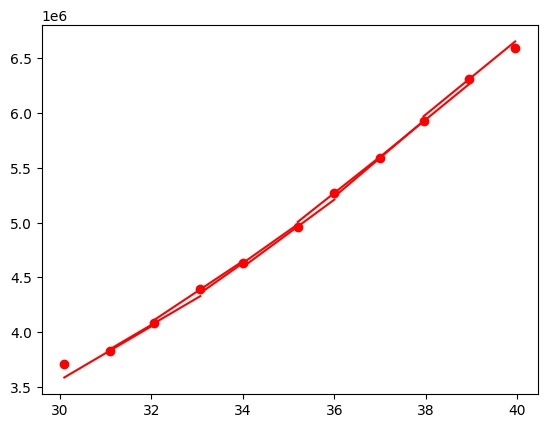

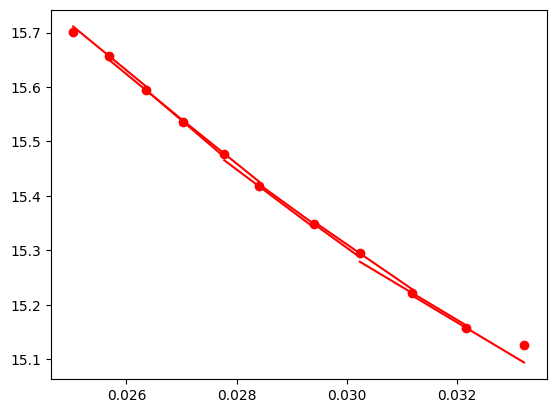

In [8]:
data = pd.read_csv("data.csv")
data["h"] = data["h1"]-data["h2"]
data["P"] = data["h"] * 9.81 * 13600
d_up = T_UP(data)
d_down = T_DOWN(data)

def calc_func(xs, ys, col1 = "r", col2 = "r"):
    plt.plot(xs, ys, f"{col1}o")
    dets = (get_values(calc_det(xs, ys)))
    TS = xs
    PS = ys
    for i in range(1, len(xs)-1):
        k = dets[i]
        t_ss = TS[i-1:i+2]
        p_ss = [(TS[i-1]-TS[i])*k + PS[i], (TS[i]-TS[i])*k + PS[i], (TS[i+1]-TS[i])*k + PS[i]]
        plt.plot(t_ss, p_ss, col2)
    return dets

dets1 = calc_func(d_up["T"], d_up["P"], "r", "r")
dets2 = calc_func(d_down["T"], d_down["P"], "g", "g")
data["k1"] = pd.Series(dets1+dets2)
plt.figure()
dets1 = calc_func(1/d_up["T"], np.log(d_up["P"]), "r", "r")
dets2 = calc_func(1/d_down["T"], np.log(d_down["P"]), "g", "g")
print(dets1)
data["k2"] = pd.Series(dets1+dets2)
data["L1"] = 8.31*data["T"]**2/data["P"]*data["k1"]
data["L2"] = -8.31*data["k2"]
data
